<a href="https://colab.research.google.com/github/jmetchebarne/ds_latam/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Challenge:
The problem consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile
(SCL). For that you will have a dataset using public and real data where each row corresponds to a flight that landed or took off
from SCL during 2017. The following information is available for each flight:

Fecha-I: Scheduled date and time of the flight.

Vlo-I : Scheduled flight number.

Ori-I : Programmed origin city code.

Des-I : Programmed destination city code.

Emp-I : Scheduled flight airline code.

Fecha-O : Date and time of flight operation.

Vlo-O : Flight operation number of the flight.

Ori-O : Operation origin city code

Des-O : Operation destination city code.

Emp-O : Airline code of the operated flight.

DIA: Day of the month of flight operation.

MES : Number of the month of operation of the flight.

AÑO : Year of flight operation.

DIANOM : Day of the week of flight operation.

TIPOVUELO : Type of flight, I =International, N =National.

OPERA : Name of the airline that operates.

SIGLAORI: Name city of origin.

SIGLADES: Destination city name.

#Solution

In [63]:
# Used libraries
import datetime
import time

import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from lightgbm import LGBMClassifier

##Question 1
How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

###Answer
Before studying the distribution of the data, we're going to study the whole set, just to get a feeling of what we are working with.

In [64]:
# If this used in google colab, please use the following prompt to load the dataset
# Left commented
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving dataset_SCL.csv to dataset_SCL (1).csv
User uploaded file "dataset_SCL (1).csv" with length 8658845 bytes


In [65]:
# df = pd.read_csv('dataset_SCL.csv', low_memory=False)
df = pd.read_csv('../data/dataset_SCL.csv', low_memory=False)

To study the whole set, first we're going to use the following:

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


From this point, we can start looking at how the data looks. As a start, we can see that columns: DIA, MES, and AÑO are the only one that are type int64, while all the others are of type object.

We are now going to look at the head of the DataFrame, to have an idea of what we are working with.

In [67]:
df.head()
# We could use also df.tail() to check the last values of the dataset aswell.

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


We write the Fecha-I and Fecha-O columns as datetimes instead of object.

In [68]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

We now check if there's any missing data. This can be either deleted or filled, depending on the dataset.

In [69]:
df.isnull().sum(axis = 0)

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

We see that there's a null value on column Vlo-O. So we check if we can fix it, or if we drop it.

In [70]:
df[df['Vlo-O'].isnull()]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Considering that Vlo-O is the flight operation number of the flight, even if it's not quite likely, it may differ from Vlo-I, the scheduled flight number, so, even if we could fill the missing value with the value at Vlo-I (200), we are going to drop this row in case the flight opertation number was changed.

In [71]:
df = df[~df['Vlo-O'].isnull()].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68205 non-null  datetime64[ns]
 1   Vlo-I      68205 non-null  object        
 2   Ori-I      68205 non-null  object        
 3   Des-I      68205 non-null  object        
 4   Emp-I      68205 non-null  object        
 5   Fecha-O    68205 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68205 non-null  object        
 8   Des-O      68205 non-null  object        
 9   Emp-O      68205 non-null  object        
 10  DIA        68205 non-null  int64         
 11  MES        68205 non-null  int64         
 12  AÑO        68205 non-null  int64         
 13  DIANOM     68205 non-null  object        
 14  TIPOVUELO  68205 non-null  object        
 15  OPERA      68205 non-null  object        
 16  SIGLAORI   68205 non-null  object       

From the preview of the data, we can see that Vlo-I and Vlo-O seems to be of int type, so we are going to see if it's just a coincidence, or it needs to be converted.

For this, we build a function that gets all the non-numerical values in a list, so we can see if the column can be converted or not.

In [72]:
def get_non_numerical_values(value_list):
  non_numerical_values = []
  for value in value_list:
    try:
      int(float(value))
    except:
      non_numerical_values = non_numerical_values + [value]
  return non_numerical_values

print('Non-numerical values in column Vlo-O: ', get_non_numerical_values(list(df['Vlo-O'].unique())))
print('Non-numerical values in column Vlo-I: ', get_non_numerical_values(list(df['Vlo-I'].unique())))

Non-numerical values in column Vlo-O:  ['71R', '201R', '43R', '401A', '401B', '802R', '114R', '622R', '492R', '338R', '591P', '846A', '502R', '207R']
Non-numerical values in column Vlo-I:  ['989P', '940P', '591P', '846A', '1104A']


We can see from the results that both column have non-float values, so we can't transform the columns into an int64 type.

We also notice that the unique value in both columns aren't equal, meaning that the assumption we did to not fill the empty value was correct.

Now, we are going to study columns that look that may be important in the dataset, such as date and the destination city name.

For this, we are going to use Univariate Analysis in the following columns: 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'OPERA'

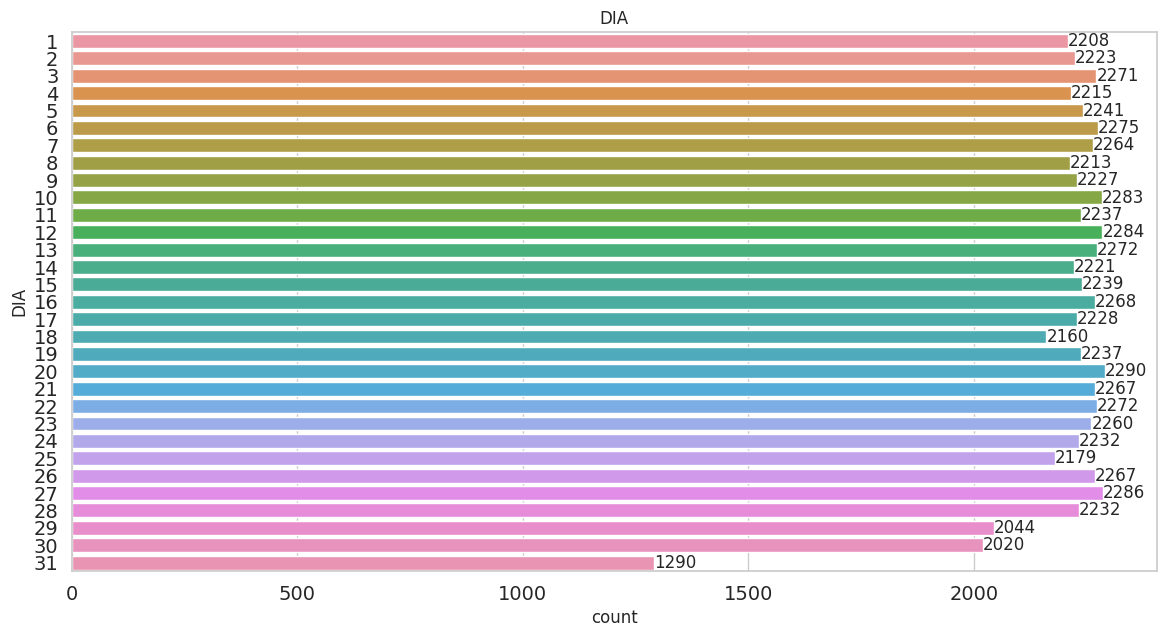

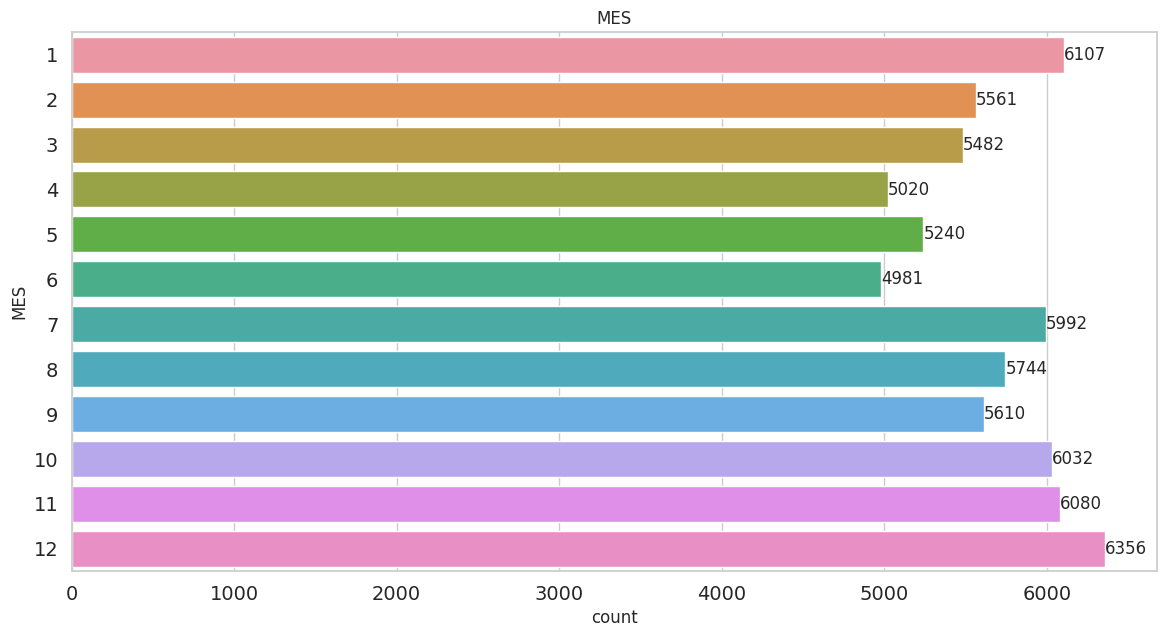

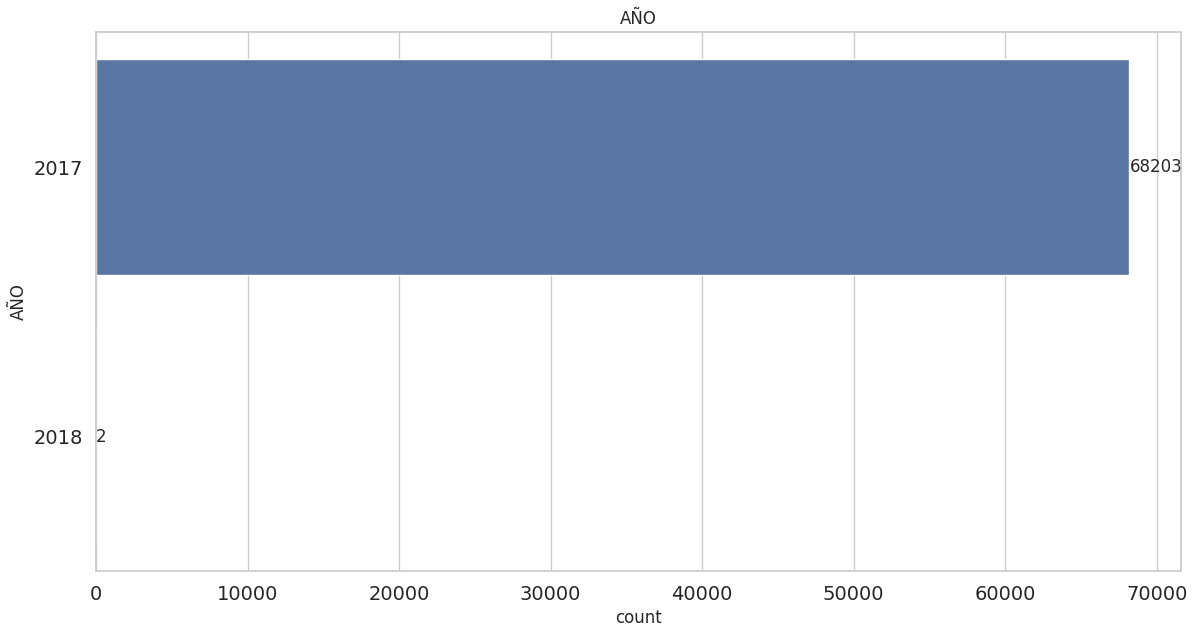

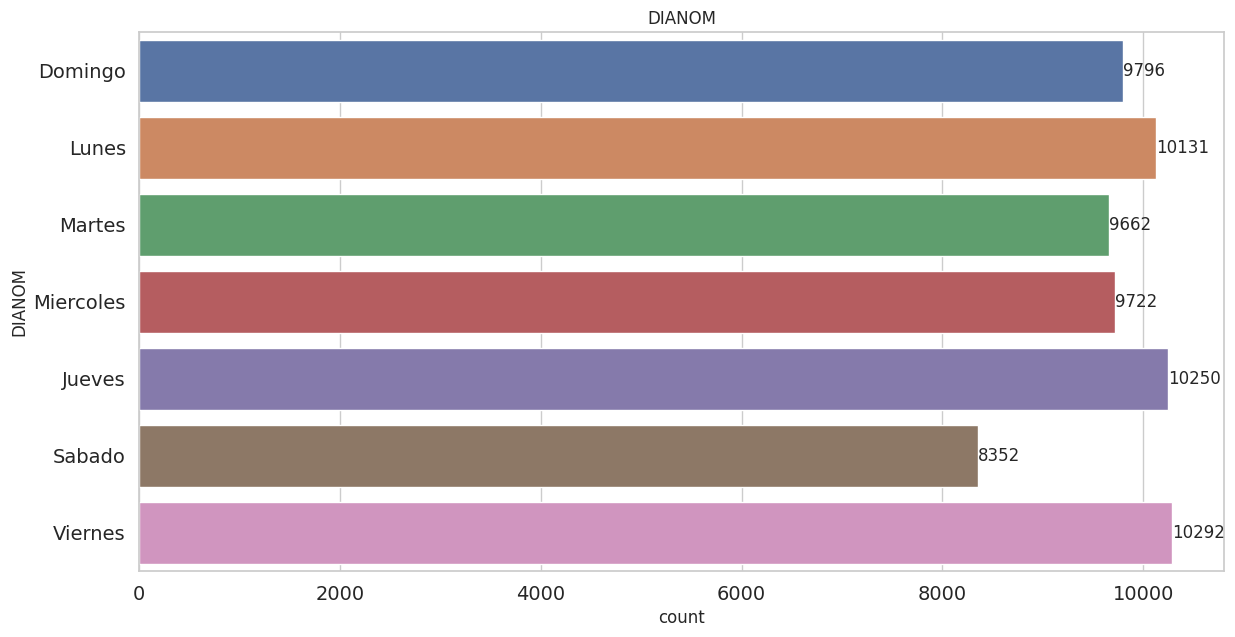

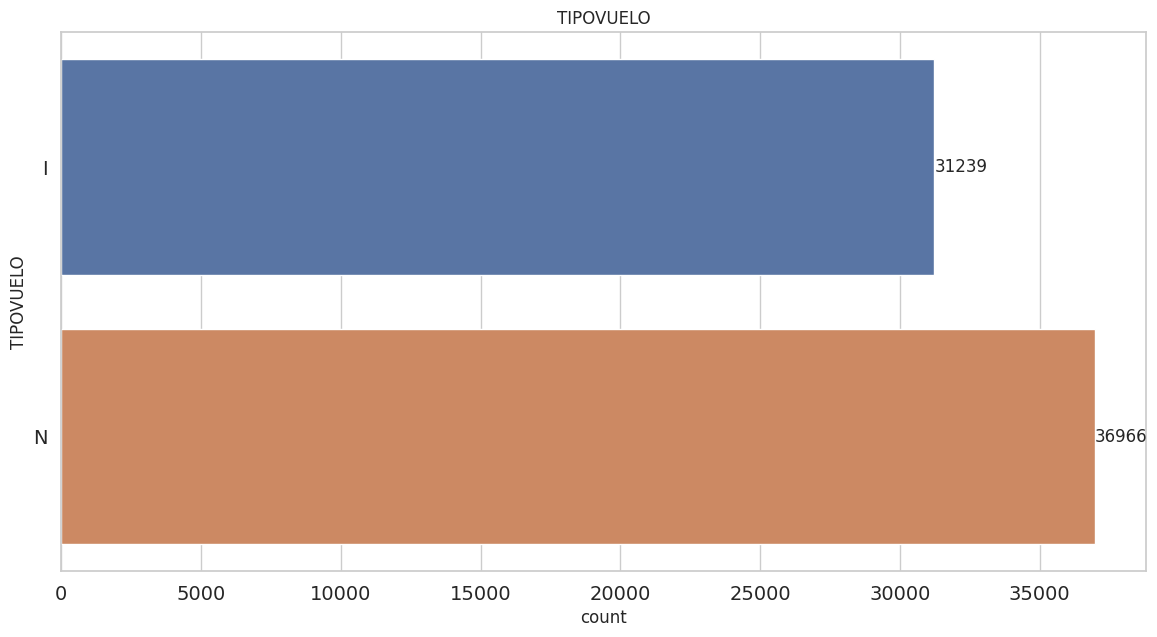

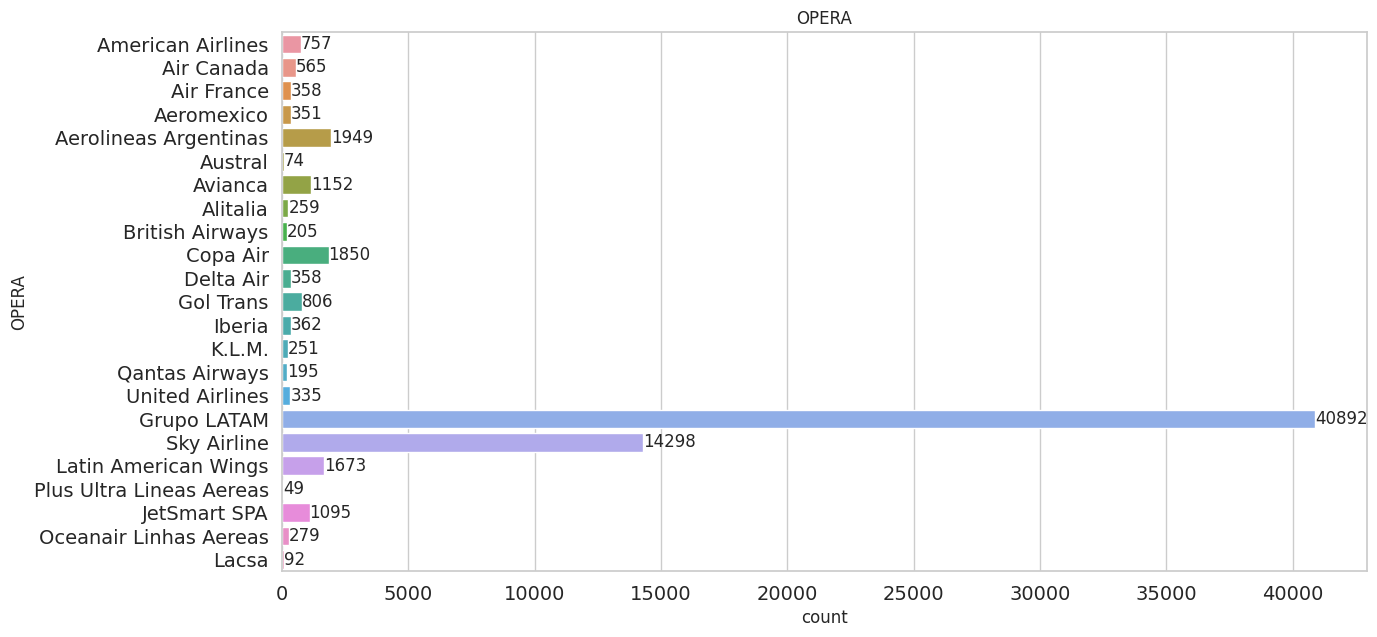

In [73]:
cols = ['DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'OPERA']

for col in cols:
  plt.figure(figsize = (14,7))
  plotting = sns.countplot(y=col, data=df)
  for container in plotting.containers:
      plotting.bar_label(container,fontsize=12)
  plt.title(f"{col}")
  plt.yticks(fontsize=14)
  plt.xticks(fontsize=14)
  plt.show()

First thing we notice here is that the 'AÑO' column has both, 2017, and 2018 values. However, it only has 2 values, so it's probably a good idea to remove those 2 rows, so the whole study is based on year 2017.

In [74]:
# 2018 values
df[df['AÑO'] == 2018]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
66917,2017-12-31 23:55:00,602,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Los Angeles
66946,2017-12-31 23:40:00,622,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico


From this table, we see that the 2018 values are from flights whose original flight schedule was in 2017, but it was delayed oto 2018. We are going to remove this 2 cases as we explained before.

In [75]:
df = df[df['AÑO'] == 2017]

###Comments about the Univariate Analysis
1) DIA: In this column we notice from the analysis that the top values are tight, while the small values are very clear to the eye. In this case, we can see that on the 29th, 30th, and specially in the 31st, the quantity of flights are considerably lower than the other days.

2) MES: From the data we can see that the months with most flights are December and January, which could be related with the summer holidays. The months with the least flights are April and June, still a bit unclear why those are particulary lower than, for example May.

3) AÑO: As we stated before, in this case we are only working with 2017 flights, so this value is now unique.

4) DIANOM: What is shown here is that the most busy days are Monday, Thursday, and Friday, probably due to business trips inside the country. We can also see that Saturday is particulary lower than the other days, which can probably be mostly explained by the same reason.

5) TIPOVUELO: National flights are slightly more than International flights.

6) OPERA: Grupo LATAM is by far the airline with the most flights, followed by Sky Airline. The quantity of flights of other companies are pretty small compared to the two alredy mentioned.

##Question 2
Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:

○ high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

○ min_diff : difference in minutes between Date-O and Date-I .

○ delay_15 : 1 if min_diff > 15, 0 if not.

○ period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .

###Answer
For this question, we are going to define a function for each new column.

In [76]:
def high_season(input_date):
  """
  high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
  """
  input_year = input_date.year

  high_season_december = (input_date >= datetime.date(input_year, 12, 15) and input_date <= datetime.date(input_year, 12, 31))
  high_season_march = (input_date >= datetime.date(input_year, 1, 1) and input_date <= datetime.date(input_year, 3, 3))
  high_season_july = (input_date >= datetime.date(input_year, 7, 15) and input_date <= datetime.date(input_year, 7, 31))
  high_season_september = (input_date >= datetime.date(input_year, 9, 11) and input_date <= datetime.date(input_year, 9, 30))

  if high_season_december or high_season_march or high_season_july or high_season_september:
    return 1
  else:
    return 0

In [77]:
def min_diff(input_days):
  """
  min_diff : difference in minutes between Date-O and Date-I .
  """
  return divmod(input_days.total_seconds(), 60)[0]

In [78]:
def delay_15(input_minutes):
  """
  delay_15 : 1 if min_diff > 15, 0 if not.
  """
  return 1 if input_minutes > 15 else 0

In [79]:
def period_day(input_hour):
  """
  period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based onDate-I .
  """
  morning = input_hour >= datetime.time(5, 0) and input_hour <= datetime.time(11, 59)
  afternoon = input_hour >= datetime.time(12, 0) and input_hour <= datetime.time(18, 59)
  early_night = input_hour >= datetime.time(19, 0) and input_hour <= datetime.time(23, 59)
  late_night = night = input_hour >= datetime.time(0, 0) and input_hour <= datetime.time(4, 59)

  if morning:
    return 'morning'

  elif afternoon:
    return 'afternoon'

  elif early_night or late_night:
    return 'night'

  else:
    return '-'

Now we generate the new columns using the defined functions to the dataframe, and we check the new generated dataframe with these new columns.

In [80]:
df['high_season'] = df['Fecha-I'].apply(lambda x: high_season(x))
df['min_diff'] = (df['Fecha-O']-df['Fecha-I']).apply(lambda x: min_diff(x)).astype(int)
df['delay_15'] = df['min_diff'].apply(lambda x: delay_15(x))
df['period_day'] = df['Fecha-I'].dt.time.apply(lambda x: period_day(x))

df.head()

<ipython-input-76-3ec23464d59f>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  high_season_december = (input_date >= datetime.date(input_year, 12, 15) and input_date <= datetime.date(input_year, 12, 31))
<ipython-input-76-3ec23464d59f>:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  high_season_march = (input_date >= datetime.date(input_year, 1, 1) and input_date <= datetime.date(input_year, 3, 3))
<ipython-input-76-3ec23464d59f>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be con

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2,0,night


We now save this new columns as a new dataset called synthetic_features.csv.

In [81]:
cols_to_keep = ['high_season', 'min_diff', 'delay_15', 'period_day']
df[cols_to_keep].to_csv('synthetic_features.csv', index=False)

We finally check that the file is saved properly using os library.

In [82]:
os.listdir()

['.config',
 'dataset_SCL (1).csv',
 'synthetic_features.csv',
 'dataset_SCL.csv',
 'sample_data']

##Question 3
What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What
variables would you expect to have the most influence in predicting delays?

###Answer
We expect that the most influentials variables are:
- Airline: Here the main fact is that the delay can come from another country, which is why I expect this to be a big cause.

- Day of the week: A busy day is probably more likely to present a delay on the flights compared to a low-traffic one.

- Season: High season should have a bigger delay rate than a non-high season because of how many flights are involved in said periods.


For this, we are going the delay flight vs the total flights as a percentage value, making it easier to spot the most influential variables.

In [83]:
delay_cols = ['DIANOM', 'MES', 'OPERA', 'TIPOVUELO', 'high_season', 'delay_15']
delay_df = df[delay_cols]

We then create a function that returns the delay percentage

In [84]:
def delay_percentage(df, col):
  """
  Compares de delay_15 column to another column
  """
  temp_df = df.groupby(col)['delay_15'].agg({np.sum, len}).reset_index()
  temp_df['delay_percentage'] = temp_df['sum']/temp_df['len']
  temp_df.columns = [col, 'total_delays', 'total_flights', 'relative_percentage']
  temp_df = temp_df[[col, 'total_delays', 'total_flights', 'relative_percentage']].sort_values('relative_percentage', ascending=False)
  return temp_df


And now, we calculate the values for each column

In [85]:
dianom_delay = delay_percentage(df,'DIANOM')
dianom_delay

,DIANOM,total_delays,total_flights,relative_percentage
6,Viernes,2285,10292,0.222017
2,Lunes,2047,10129,0.202093
1,Jueves,2045,10250,0.199512
4,Miercoles,1661,9722,0.170850
3,Martes,1634,9662,0.169116
5,Sabado,1363,8352,0.163194
0,Domingo,1578,9796,0.161086


While there is a noticeable difference between the flight delays percentage per day, it probably isn't as impactful as the other variables to be seen.

In [86]:
mes_delay = delay_percentage(df,'MES')
mes_delay

,MES,total_delays,total_flights,relative_percentage
6,7,1758,5992,0.293391
11,12,1615,6356,0.254091
9,10,1363,6032,0.225962
10,11,1199,6080,0.197204
7,8,996,5744,0.173398
8,9,967,5610,0.172371
5,6,852,4981,0.171050
0,1,977,6105,0.160033
4,5,827,5240,0.157824
1,2,843,5561,0.151591


The MES value does have a high relative porcentage in the delay flights. In particular, the first 2 months: July and December, are both months in high season, where people travel a lot, which may influence this behaviour.

In [87]:
opera_delay = delay_percentage(df,'OPERA')
opera_delay

,OPERA,total_delays,total_flights,relative_percentage
19,Plus Ultra Lineas Aereas,30,49,0.612245
20,Qantas Airways,113,195,0.579487
2,Air Canada,258,565,0.456637
17,Latin American Wings,681,1673,0.407053
11,Gol Trans,287,806,0.356079
7,Avianca,306,1152,0.265625
0,Aerolineas Argentinas,468,1949,0.240123
6,Austral,15,74,0.202703
14,JetSmart SPA,196,1095,0.178995
12,Grupo LATAM,7305,40890,0.178650


We notice that some OPERA values are very rare, which is disrupting our analysis. For this, we are only going to consider those values with over 1000 total flights from now on.

In [88]:
opera_delay[opera_delay['total_flights'] > 1000].head(10)

,OPERA,total_delays,total_flights,relative_percentage
17,Latin American Wings,681,1673,0.407053
7,Avianca,306,1152,0.265625
0,Aerolineas Argentinas,468,1949,0.240123
14,JetSmart SPA,196,1095,0.178995
12,Grupo LATAM,7305,40890,0.178650
21,Sky Airline,2540,14298,0.177647
9,Copa Air,116,1850,0.062703


We can clearly see here that this variable has very high influence in delays. As an example, if we pick a flight from this dataset operated by Latin American Wings, over 40% of those flights are going to have a delay, meanwhile for Copa Air, it's below 6.5%.

In [89]:
tipovuelo_delay = delay_percentage(df,'TIPOVUELO')
tipovuelo_delay[tipovuelo_delay['total_flights'] > 1000].head(10)

,TIPOVUELO,total_delays,total_flights,relative_percentage
0,I,7047,31237,0.225598
1,N,5566,36966,0.150571


We notice that international flights have a higher percentage of delay flights compared to the national counterpart, which may be related to the airports of other countries not been as strict on time.

In [90]:
high_season_delay = delay_percentage(df,'high_season')
high_season_delay[high_season_delay['total_flights'] > 1000].head(10)

,high_season,total_delays,total_flights,relative_percentage
1,1,4469,22759,0.196362
0,0,8144,45444,0.179210


In the high_season case, we see that there isn't quite a significative difference between high season or not, so it's not something to blame for the delays.

From this analysis, we can confirm that OPERA and MES are the two most influential variables from the ones we picked for this analysis. Meaning that if you fall in one of this groups, you are likely to be delayed on your flight.

##Question 4
Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
Feel free to generate additional variables and/or supplement with external variables.

###Answer
We are going to pick 3 common models for this question:

- LightGBM

- Random Forest

- K-Nearest Neighbour


In order to evaluare performance, we are going to use the confusion matrix:

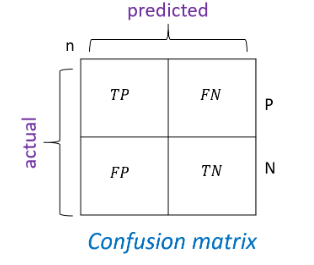

Where:

TP: True positives (Predicted true, actually true)

TN: True negatives (Predicted false, actually false)

FP: False positives (Predicted true, actually false)

FN: True negatives (Predicted false, actually true)

The metrics we are going to use are:

Accuracy: (TP + TN) / (TP + TN + FP + FN)

Recall: TP / (TP + FN)

Precision: TP / (TP + FP)

F-Score: 2 * (Precision * Recall) / (Precision + Recall)

First, we need to apply a label encoder to the categorical columns, in order to be able to apply the next steps, which require numerical columns

In [91]:
def label_encoder(df, col):
  """
  Adds label_encoder to the requested column
  """
  df[col] = LabelEncoder().fit_transform(df[col])

In [92]:
to_be_labelled_list = ['DIANOM', 'MES', 'OPERA', 'TIPOVUELO', 'high_season', 'period_day']

for col in to_be_labelled_list:
  label_encoder(df, col)

We now split the dataset in train and test

In [93]:
X = df[to_be_labelled_list]
Y = df['delay_15']

# We fix the random state, so the exact same result is present in all executions, only for this challenge.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

Now we define the functions that return the metrics, and the functions for each model.

In [94]:
models = {
    'LightGBM': LGBMClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNeighors': KNeighborsClassifier()
}

In [95]:
def classification_metrics(df):
  """
  Returns a DataFrame with the classification metrics
  """
  result_df = pd.DataFrame()
  y_true = df['y']
  y_pred = df['yhat']

  result_df['accuracy'] = [round(accuracy_score(y_true,y_pred),4)]
  result_df['recall'] = [round(recall_score(y_true,y_pred, average="macro"),4)]
  result_df['precision'] = [round(precision_score(y_true,y_pred, average="macro"),4)]
  result_df['fscore'] = [round(f1_score(y_true,y_pred, average="macro"),4)]

  return result_df

In [96]:
result  = []

for model_name, model in models.items():
  start_time = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  end_time = time.time()
  execution_time = end_time - start_time

  metrics = classification_metrics(pd.DataFrame({'y': y_test, 'yhat': y_pred}))
  metrics = metrics.assign(model = model_name, time = execution_time)

  result.append(metrics)



We now see the results of the algorithms, for this, we need to build the Dataframe.

In [97]:
cols = ['model', 'time', 'accuracy', 'recall', 'precision', 'fscore']
models_df = pd.concat(result).sort_values('accuracy', ascending = False)[cols]
models_df

,model,time,accuracy,recall,precision,fscore
0,LightGBM,1.201311,0.8191,0.5367,0.7166,0.5247
0,Random Forest,2.895593,0.8142,0.5477,0.6687,0.5462
0,KNeighors,0.715705,0.7899,0.5584,0.6041,0.5646


This values can be further improved with hyperparameters models such as Optuna or GridSearchCV.

##Question 5
Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used
to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in
the prediction task? How could you improve the Performance?

###Answer

To evaluate the models, we are going to use the following metrics:

*   Precision: We chose this metric because the impact that the false positive is high, in case that a delay is predicted, but it didn't happen at all, can be a bit messy for a the landing zones.

*   Recall: In the same way, the cost of not predicting a real delay is high, so this is a metric that should be highly considered aswell.

Generally speaking, all models did relatively similar. However, when we consider the time variable, or in other words, if we use a bigger dataset, LightGBM is by far the fastest model at this point, while still getting great results.



With that said, we are going to pick LightGBM as our best model. We now study the results with said model.

In [98]:
model = LGBMClassifier()
model.fit(X_train, y_train)

feature_importances = pd.DataFrame({'Feature': to_be_labelled_list, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

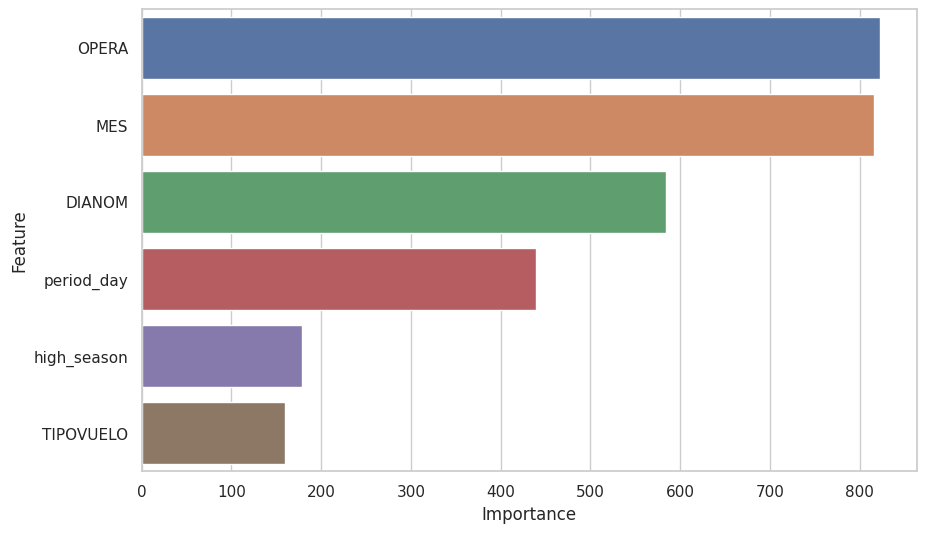

In [99]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.barplot(data=feature_importances, x="Importance", y="Feature")
plt.show()

As stated before, this can be further improved by using an hyperparameter optimizer algorithm, such as GridSearch or Optuna.

From the results, we can see that the most influential features for delay-flights predictions are:

* OPERA: Meaning that the company in charge of the operation of the flight is very influential for delays.

* MES: Certain months are much more consistent than others at keeping their original flight schedule, which may imply that holidays are actually much more important at predicting delays than we first thought.